In [ ]:
from fastai2.vision.all import *


In [ ]:
df= pd.read_csv('train.csv')
df['Image']= 'Train Images/'+df['Image']

In [ ]:
df.head()

In [39]:
tfms = [Rotate(draw=10., p=1), Zoom(draw=1.1, draw_x=0.5, draw_y=0.5, p=1.)]
comp = setup_aug_tfms([Rotate(draw=10., p=1), Zoom(draw=1.1, draw_x=0.5, draw_y=0.5, p=1.),RandomErasing(p=1., max_count=6)])

In [40]:
datablk = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_x=ColReader(cols='Image'), 
                 splitter=RandomSplitter(),
                 get_y=ColReader(cols='Class'),
                 item_tfms=Resize(80),
                 batch_tfms=comp )

In [41]:
datablk.summary(df)

Setting-up type transforms pipelines
0      Train Images/image7042.jpg    Food
1      Train Images/image3327.jpg    misc
2     Train Images/image10335.jpg  Attire
3      Train Images/image8019.jpg    Food
4      Train Images/image2128.jpg  Attire
...                           ...     ...
5978   Train Images/image2494.jpg    Food
5979   Train Images/image8015.jpg  Attire
5980   Train Images/image4975.jpg    Food
5981   Train Images/image1222.jpg    Food
5982   Train Images/image9635.jpg  Attire

[5983 rows x 2 columns]
Found 5983 items
2 datasets of sizes 4787,1196
Setting up Pipeline: ColReader -> PILBase.create
Setting up Pipeline: ColReader -> Categorize

Building one sample
  Pipeline: ColReader -> PILBase.create
    starting from
      Image    Train Images/image10203.jpg
Class                           Food
Name: 3344, dtype: object
    applying ColReader gives
      Train Images/image10203.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=80x53
  Pipeline: ColRea

In [42]:
dls = datablk.dataloaders(df, num_workers=0)


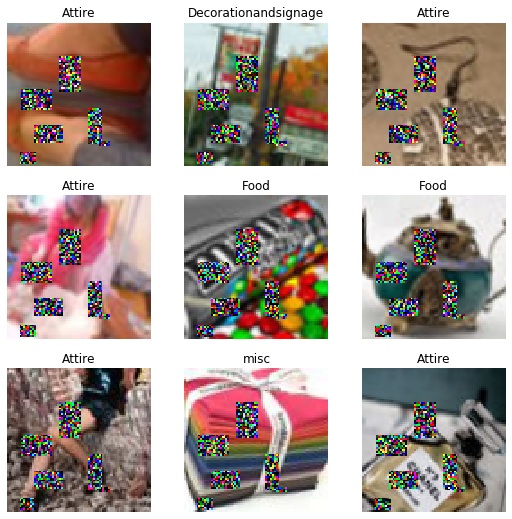

In [43]:
dls.show_batch()

In [45]:
auc =F1Score(average='weighted')

In [ ]:
def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)

In [47]:
learn=cnn_learner(dls,densenet121,metrics=[accuracy,auc],wd=1e-2).to_fp16()

In [ ]:
learn.fine_tune(10, freeze_epochs=10)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.943836,1.258345,0.523411,0.521939,00:37
1,1.657490,1.117822,0.622910,0.608316,00:34
2,1.483161,1.180773,0.634615,0.606518,00:34
3,1.367669,0.979002,0.642140,0.635606,00:34
4,1.269422,0.963549,0.682274,0.671073,00:34


In [25]:
test_df = pd.read_csv('test.csv')
sub_df=test_df.copy()
test_df['Image']='Test Images/'+test_df['Image']


In [26]:
tst_dl = dls.test_dl(test_df)


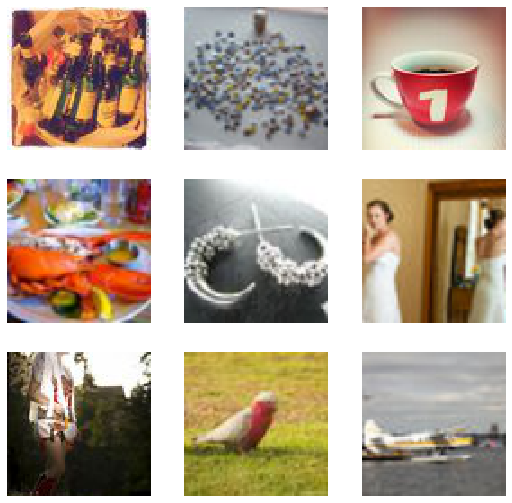

In [27]:
tst_dl.show_batch()

In [28]:
preds,_=learn.get_preds(dl=tst_dl)

In [34]:
sub_df['Class']=preds.argmax(axis=-1)
sub_df['Class']=sub_df['Class'].apply(lambda x : dls.vocab[x])

In [35]:
sub_df.to_csv('densenet121_overfit_tta4.csv',index=False)

In [31]:
preds,a=learn.tta(dl=tst_dl)

In [33]:
a